In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from xgboost import XGBRegressor
import joblib

2024-06-15 20:34:40.593526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 20:34:40.847258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-06-15 20:34:40.847315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-15 20:34:40.898835: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [109]:
pfts = ["Tropical", "Temperate_Broadleaf","Temperate_Deciduous"
        ,"Temperate_Coniferous","Boreal"]

var_list = ['GPP', 'NPP', 'VEGC', 'SOILORGC']


In [136]:
pft = pfts[3]
all_model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/merged_outliers_removed/'+pft+'_cru_hist_canesm5_ssp245.csv')


In [137]:
all_model_data['year'].max()

2100

In [138]:
### get 15% hold out
pred_vars = ['ordinal_stand_age'
                         ,'nirr_avg', 'nirr_min', 'nirr_max', 'prec_avg',
       'prec_min', 'prec_max', 'tair_avg', 'tair_min', 'tair_max',
       'trange_avg', 'trange_min', 'trange_max', 'vpr_avg',
       'vpr_min', 'vpr_max', 'wind_avg', 'wind_min', 'wind_max','s1', 's2', 'co2']
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
# Get the indices and split them
indices = np.arange(len(all_model_data))
indices
train_indices, test_indices = train_test_split(indices, test_size=0.15, random_state=42)

# # Split the data using train_indices and test_indices
X_train, X_test = all_model_data.loc[train_indices,pred_vars], all_model_data.loc[test_indices,pred_vars]
Y_train, Y_test = all_model_data.loc[train_indices, var_list], all_model_data.loc[test_indices, var_list]

train_all_model_data = all_model_data.loc[train_indices]


In [139]:
var = 'NPP'
pft

'Temperate_Coniferous'

In [1]:
.16*1000

160.0

In [140]:
year_results = pd.DataFrame()

for year in range(1920, 2101, 20):
    print(year)

    X_train_sub = train_all_model_data.loc[train_all_model_data['year']<=year,pred_vars]
    Y_train_sub = train_all_model_data.loc[train_all_model_data['year']<=year, var_list]
    depth = 12
    lr = 0.1
    xgb_model = XGBRegressor(max_depth=depth, learning_rate=lr)

    xgb_model.fit(X_train_sub, Y_train_sub[var])

    #     # Save the model
    # model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    # joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train and X_test
    Y_train_sub[var+'_pred'] = xgb_model.predict(X_train_sub)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train_sub[var], Y_train_sub[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train_sub[var], Y_train_sub[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train_sub[var+'_pred'] - Y_train_sub[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

# Store the results in the list
    year_results = pd.concat([year_results, pd.DataFrame({
        'Variable': [var],
        'year': [year],
        'R2 Train': [r2_train],
        'R2 Test': [r2_test],
        'RMSE Train': [rmse_train],
        'RMSE Test': [rmse_test],
        'Bias Train': [bias_train],
        'Bias Test': [bias_test]
    })])
year_results.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/year_results_{pft}_{var}.csv', index=False)
year_results

1920
1940
1960
1980
2000
2020
2040
2060
2080
2100


,Variable,year,R2 Train,R2 Test,RMSE Train,RMSE Test,Bias Train,Bias Test
0,NPP,1920,0.918918,0.494602,7.399883,19.375861,0.000192,-0.184981
0,NPP,1940,0.900798,0.547618,8.266337,18.331445,-0.000028,0.388135
0,NPP,1960,0.887614,0.580781,8.833906,17.646737,-0.000074,-1.518251
0,NPP,1980,0.871770,0.609610,9.334421,17.029172,-0.000115,-1.673449
0,NPP,2000,0.859367,0.634977,9.864607,16.466606,-0.000104,-1.299320
0,NPP,2020,0.837566,0.684695,10.715173,15.304176,-0.000043,-0.094359
0,NPP,2040,0.825639,0.725756,11.173138,14.272908,-0.000111,-0.091423
0,NPP,2060,0.813154,0.753959,11.636722,13.519095,-0.000132,-0.289670
0,NPP,2080,0.802251,0.772752,12.056157,12.992532,-0.000192,0.025078
0,NPP,2100,0.789580,0.777092,12.490803,12.867890,-0.000146,-0.012475


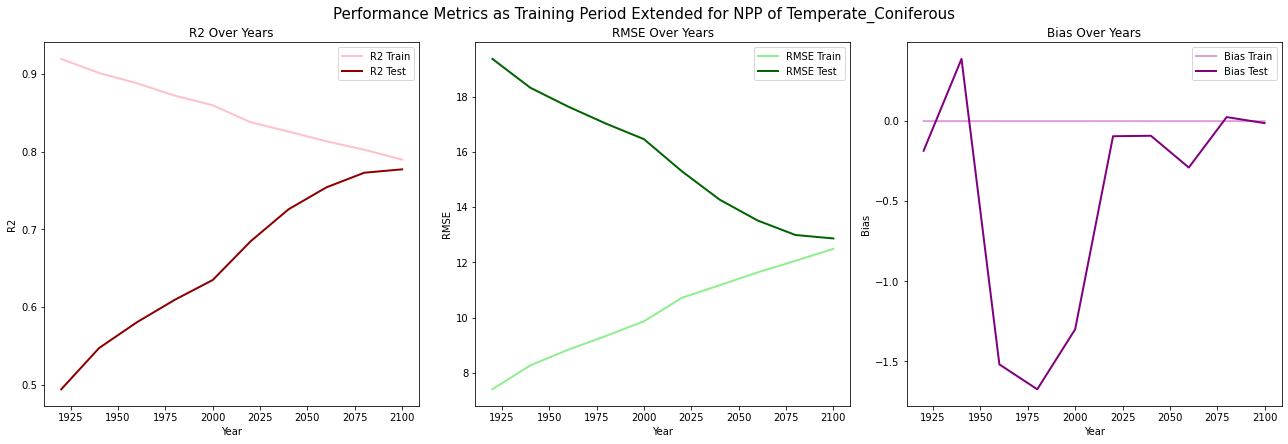

In [141]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot R2 Train and Test with pink color
axs[0].plot(year_results['year'], year_results['R2 Train'], label='R2 Train', color='pink', linestyle='-', linewidth=2)
axs[0].plot(year_results['year'], year_results['R2 Test'], label='R2 Test', color='darkred', linestyle='-', linewidth=2)
axs[0].set_title('R2 Over Years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('R2')
axs[0].legend()

# Plot RMSE Train and Test with green color
axs[1].plot(year_results['year'], year_results['RMSE Train'], label='RMSE Train', color='lightgreen', linestyle='-', linewidth=2)
axs[1].plot(year_results['year'], year_results['RMSE Test'], label='RMSE Test', color='darkgreen', linestyle='-', linewidth=2)
axs[1].set_title('RMSE Over Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# Plot Bias Train and Test with orange color
axs[2].plot(year_results['year'], year_results['Bias Train'], label='Bias Train', color='plum', linestyle='-', linewidth=2)
axs[2].plot(year_results['year'], year_results['Bias Test'], label='Bias Test', color='purple', linestyle='-', linewidth=2)
axs[2].set_title('Bias Over Years')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Bias')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.suptitle(f"Performance Metrics as Training Period Extended for NPP of {pft}", y=1.02, fontsize=15)

# Show the plots
plt.show()

In [142]:
percentile_results = pd.DataFrame()

for percentile in [.2, .3, .4, .5, .6, .7, .8, .9, 1]:
    print(percentile)
    X_train_sub, X_test_sub, Y_train_sub, Y_test_sub = train_test_split(X_train, Y_train
                    , test_size=percentile, random_state=42)


    depth = 12
    lr = 0.1
    xgb_model = XGBRegressor(max_depth=depth, learning_rate=lr)
    xgb_model.fit(X_train_sub, Y_train_sub[var])

    #     # Save the model
    # model_filename = f'/home/smmrrr/TEM_Analysis/TEM_Analysis/models/xgb_model_{var}_{pft}.joblib'
    # joblib.dump(xgb_model, model_filename)
    # Get predictions for X_train_sub and X_test
    Y_train_sub[var+'_pred'] = xgb_model.predict(X_train_sub)
    Y_test[var+'_pred'] = xgb_model.predict(X_test)

    r2_train = r2_score(Y_train_sub[var], Y_train_sub[var+'_pred'])
    r2_test = r2_score(Y_test[var], Y_test[var+'_pred'])
    rmse_train = np.sqrt(mean_squared_error(Y_train_sub[var], Y_train_sub[var+'_pred']))
    rmse_test = np.sqrt(mean_squared_error(Y_test[var], Y_test[var+'_pred']))
    bias_train = np.mean(Y_train_sub[var+'_pred'] - Y_train_sub[var])
    bias_test = np.mean(Y_test[var+'_pred'] - Y_test[var])

    # Store the results in the list
    percentile_results = pd.concat([percentile_results, pd.DataFrame({
        'Variable': [var],
        'percentile': [percentile],
        'R2 Train': [r2_train],
        'R2 Test': [r2_test],
        'RMSE Train': [rmse_train],
        'RMSE Test': [rmse_test],
        'Bias Train': [bias_train],
        'Bias Test': [bias_test]
    })])

percentile_results.to_csv(f'/home/smmrrr/TEM_Analysis/TEM_Analysis/model_data/model_output/percentile_results_{pft}_{var}.csv', index=False)

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1


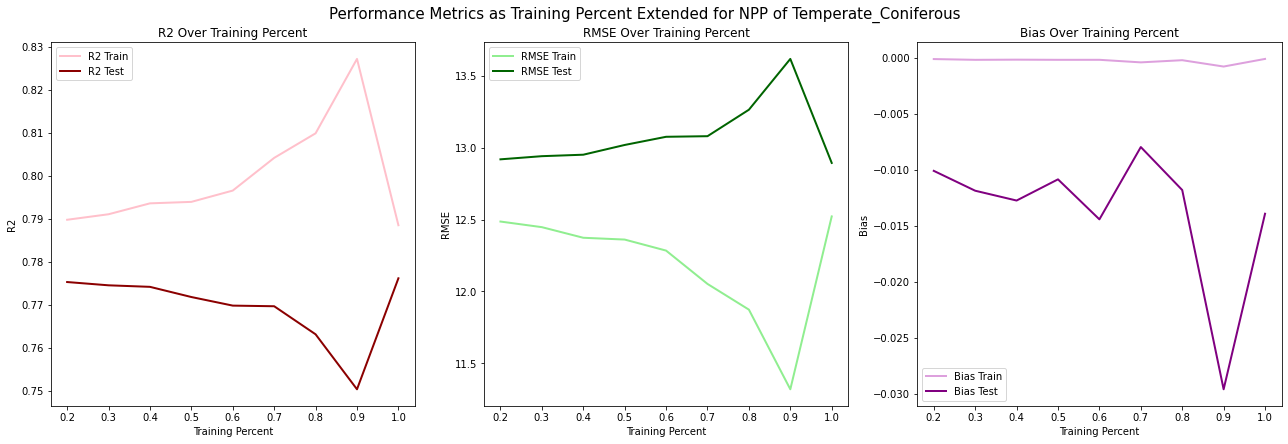

In [143]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot R2 Train and Test with pink color
axs[0].plot(percentile_results['percentile'], percentile_results['R2 Train'], label='R2 Train', color='pink', linestyle='-', linewidth=2)
axs[0].plot(percentile_results['percentile'], percentile_results['R2 Test'], label='R2 Test', color='darkred', linestyle='-', linewidth=2)
axs[0].set_title('R2 Over Training Percent')
axs[0].set_xlabel('Training Percent')
axs[0].set_ylabel('R2')
axs[0].legend()

# Plot RMSE Train and Test with green color
axs[1].plot(percentile_results['percentile'], percentile_results['RMSE Train'], label='RMSE Train', color='lightgreen', linestyle='-', linewidth=2)
axs[1].plot(percentile_results['percentile'], percentile_results['RMSE Test'], label='RMSE Test', color='darkgreen', linestyle='-', linewidth=2)
axs[1].set_title('RMSE Over Training Percent')
axs[1].set_xlabel('Training Percent')
axs[1].set_ylabel('RMSE')
axs[1].legend()

# Plot Bias Train and Test with orange color
axs[2].plot(percentile_results['percentile'], percentile_results['Bias Train'], label='Bias Train', color='plum', linestyle='-', linewidth=2)
axs[2].plot(percentile_results['percentile'], percentile_results['Bias Test'], label='Bias Test', color='purple', linestyle='-', linewidth=2)
axs[2].set_title('Bias Over Training Percent')
axs[2].set_xlabel('Training Percent')
axs[2].set_ylabel('Bias')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.suptitle(f"Performance Metrics as Training Percent Extended for NPP of {pft}", y=1.02, fontsize=15)

# Show the plots
plt.show()